In [97]:
"""
Plotte Auslastung der Intensivbetten der Bundesländer

Plot intensive bed usage of each German federal state
"""
# !pip install requests lxml pandas matplotlib numpy
import os
from typing import Dict, List, Tuple, Callable
from time import sleep
from datetime import datetime

import csv
import requests
import lxml.html.soupparser as soupparser
import lxml.etree as etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def get_html(url: str, params: Dict = None, retries: int = 10) -> str:
    """
    Download DIVI html.
    """
    params = params if params else {}

    nap_time = 200
    while retries:
        resp = requests.post(url, params=params)
        if resp.status_code == 200:
            return resp.text
        sleep(nap_time)
        nap_time *= 2
        retries -= 1
    raise Exception("No response.")


def to_dataframe(html: str) -> pd.DataFrame:
    """
    Turn html tables into into a dictionary.
    * respects <small/>-tags in first column
    * respects classes of <span/>-tags in columns where there's no content
    * empty cells will be contained as empty strings `""`
    * converts dates in last column to datetime objects
    """
    STRESS = {'green': 1.0, 'yellow': 0.5, 'red': 0.0, 'unavailable': np.nan}
    
    result = list()
    table = soupparser.fromstring(html) \
            .xpath("/html/body/div/div/div/div/div/div/form/div/div/table")[0]

    headers = [x.text_content().strip() for x in table.xpath("thead//th")]
    result = {head: [] for head in headers}

    for table_row in table.xpath("tbody/tr"):
        table_row_cells = list()
        for i, cell in enumerate(table_row.xpath("td")):
            cell_content = cell.text_content().replace("\n", " ")
            
            # first column contains <small/> tags
            if i == 0:
                smalls = cell.xpath("small")
                texts = [cell.text]
                texts += [s.text for s in smalls if len(s) and s.text]
                cell_content = ", ".join(texts)
                
            cell_content = cell_content.strip()

            # there are three columns that contain just <span/> tags with specific classes
            spans = cell.xpath("span")
            if spans:
                cell_content = STRESS[spans[0].get('class').replace("hr-icon-", '')]

            if i == 6:
                cell_content = datetime.strptime(cell_content, '%d.%m.%Y %H:%M')
                
            result[headers[i]].append(cell_content)
            
    return pd.DataFrame(result)

## start scraping finally

In [98]:
df = to_dataframe(get_html(
    url="https://divi.de/register/intensivregister?view=items",
    params={
        "filter[search]": "",
        "list[fullordering]": "a.title+ASC",
        "list[limit]": 0,
        "filter[federalstate]": 0,
        "filter[chronosort]": 0,
        "filter[icu_highcare_state]": "",
        "filter[ecmo_state]": "",
        "filter[ards_network]": "",
        "limitstart": 0,
        "task": "",
        "boxchecked": 0,
        "07b860ef6bacf3cbfc30dc905ef94486": 1}))
df

,Klinikname,Kontakt,Bundesland,ICU low care¹,ICU high care²,ECMO³,Stand
0,"Asklepios Fachklinikum Brandenburg, Neurologis...",N4 Website,BB,1.0,0.0,NaN,2020-03-24 15:08:00
1,Karl-Hansen-Klinik Bad Lippspringe,Intensiv I und II Website,NRW,1.0,1.0,1.0,2020-03-24 14:45:00
2,Marienhausklinik St. Josef Kohlhof,Website,SL,0.0,1.0,NaN,2020-03-24 14:39:00
3,"Dreifaltigkeits-Hospital gem. GmbH, Lippstadt",Intensivstation Website,NRW,0.0,1.0,NaN,2020-03-24 15:09:00
4,"Universitätskinderklinik Bonn, Neonatologie un...",Pädiatrische Intensivstation Website,NRW,1.0,1.0,1.0,2020-03-24 14:30:00
...,...,...,...,...,...,...,...
611,Universitätsklinikum Bonn,Operative Intensivmedizin Website,NRW,1.0,1.0,1.0,2020-03-22 15:55:00
612,Klinikum Nürnberg,Website,BY,1.0,1.0,1.0,2013-03-20 09:26:00
613,Helios Klinikum Bad Saarow,"ITS 1, ITS 2, ITS 3 Website",BB,0.5,1.0,1.0,2020-03-24 07:15:00
614,Elisabeth-Krankenhaus Essen,kardiologisch- internistische Intensivstation ...,NRW,1.0,1.0,1.0,2020-03-24 11:12:00


## Look deeper

In [103]:
df = df.drop('Kontakt', axis=1)
df.describe()

,ICU low care¹,ICU high care²,ECMO³
count,616.000000,616.000000,203.000000
mean,0.809253,0.867695,0.689655
std,0.335773,0.277817,0.430566
min,0.000000,0.000000,0.000000
25%,0.500000,1.000000,0.250000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


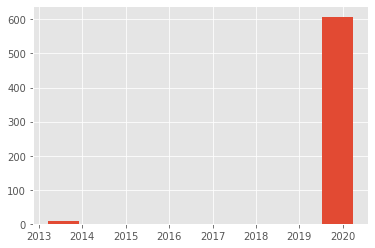

In [109]:
df['Stand'].hist()

## Plot using mean of values

Text(0, 0.5, 'federal state')

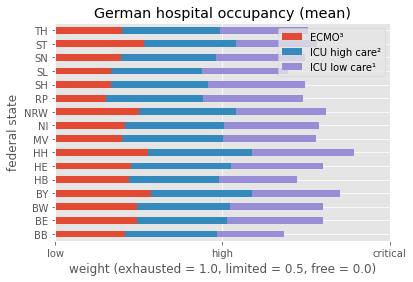

In [110]:
plt.style.use('ggplot')
df \
.replace({'red': 1.0, 'yellow': 0.5, 'green': 0.0, 'unavailable': np.nan}) \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO³', 'ICU high care²', 'ICU low care¹'], stacked=True)
plt.title("German hospital occupancy (mean)")
plt.xlabel("weight (exhausted = 1.0, limited = 0.5, free = 0.0)")
plt.xticks([0.0, 1.5, 3.0],["low", "high", "critical"])
plt.ylabel("federal state")

## Plot using median of values

Text(0, 0.5, 'federal state')

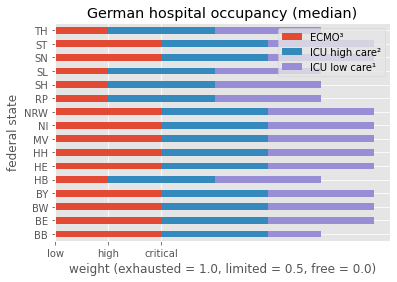

In [111]:
plt.style.use('ggplot')
df \
.replace({'red': 1.0, 'yellow': 0.5, 'green': 0.0, 'unavailable': np.nan}) \
.groupby('Bundesland').median().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO³', 'ICU high care²', 'ICU low care¹'], stacked=True)
plt.title("German hospital occupancy (median)")
plt.xlabel("weight (exhausted = 1.0, limited = 0.5, free = 0.0)")
plt.xticks([0.0, 0.5, 1.0],["low", "high", "critical"])
plt.ylabel("federal state")